# DATA AUGMENTATION
The notebook is structures as follows: 
- first, the original dataset is processed so that we can avoid data leakgage in the modeling phase;
- second, different techniques of data augmentation were performed. 
- Third, different models were trained, tuned, and evaluated on the augmented data.

No improvements were observed. 

### IMPORTING NEEDED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import yellowbrick
import shap
import vaex
import vaex.ml
import datetime as dt
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer
import datetime as dt

## CLASSIFICATION TASK

#### IMPORTING DATASET

In [6]:
#visualizing all the columns 
pd.set_option('display.max_columns',None)
#importing origanal dataset
df = pd.read_csv('SupplyChainDataset.csv')

### TRASFORMING THE ORIGINAL DATASET INTO GROUPED DATASET

In [12]:
#transforming the original dataset into a grouped dataset
agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipping (real)': 'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    #'Category Id': lambda x: ','.join(x.unique()),
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]

### PREPROCESSING

In [13]:
import datetime as dt
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

grouped_df['InvoiceMonth'] = grouped_df['order date (DateOrders)_first'].apply(get_month)
grouping = grouped_df.groupby('Customer Id_first')['InvoiceMonth']
grouped_df['CohortMonth'] = grouping.transform('min')
grouping_days = grouped_df.groupby('Customer Id_first')['order date (DateOrders)_first']
grouped_df['Cohortdays']  = grouping_days.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(grouped_df, 'order date (DateOrders)_first')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(grouped_df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day
grouped_df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
grouped_df['CohortIndex_days'] = Day_Diff.dt.days

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming you have a DataFrame named 'grouped_data' with a column 'Category Name' containing comma-separated values
# Convert the comma-separated strings to lists
grouped_df['Category Name_<lambda>'] = grouped_df['Category Name_<lambda>'].apply(lambda x: x.split(','))

from sklearn.preprocessing import MultiLabelBinarizer
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'Category Name' column
category_name_encoded = mlb.fit_transform(grouped_df['Category Name_<lambda>'])

# Create a new DataFrame with binary features for each unique item in 'Category Name'
category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)

# Combine the new binary features with the original DataFrame
grouped_df = pd.concat([grouped_df.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek

grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()

In [14]:
class PreprocessDataFrame_classification:
    def __init__(self, df):
        self.df = df

    def add_target_variable(self):
        self.df['Is_Fraud'] = self.df['Order Status_first'].apply(lambda x: 1 if x=='SUSPECTED_FRAUD' else 0)
        return self.df
    
    def drop_canceled(self):
        self.df = self.df[self.df['Order Status_first'] != 'CANCELED']
        return self.df

    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude_first'].astype('str') + '-' + 'LO' + self.df['Longitude_first'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order City_first')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

grouped_df = PreprocessDataFrame_classification(grouped_df).add_target_variable()
grouped_df = PreprocessDataFrame_classification(grouped_df).drop_canceled()
grouped_df = PreprocessDataFrame_classification(grouped_df).augment_with_network_features()
grouped_df = grouped_df.drop('Order Status_first', axis=1)
    
X = grouped_df[[i for i in grouped_df.columns if i != 'Is_Fraud']]
X = grouped_df.drop(['Order_Month','Order_Day','Order_Weekday', 'order date (DateOrders)_first', 'InvoiceMonth',
                    'CohortMonth', 'Cohortdays', 'Is_Fraud', 'Customer Id_first', 'Delivery Status_first', "Days for shipping (real)_first"],axis=1)

y = grouped_df['Is_Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

X_train = vaex.from_pandas(df=X_train, copy_index=False)
X_test = vaex.from_pandas(df=X_test, copy_index=False)
ohe = vaex.ml.OneHotEncoder(features=["Type_first", 
                                      "Customer Segment_first",'Shipping Mode_first'])
X_train = ohe.fit_transform(df=X_train)
X_test = ohe.transform(X_test)

mhe = vaex.ml.MultiHotEncoder(features=["Order City_first", "Customer City_first", 'Order State_first', 'Customer State_first'])
X_train = mhe.fit_transform(df=X_train)
X_test = mhe.transform(X_test)

X_train = X_train.to_pandas_df()
X_test = X_test.to_pandas_df()

X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

## Data Augmentation techniques

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE 
from imblearn.over_sampling import KMeansSMOTE

#### UNDERSAMPLING

In [18]:
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [19]:
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_resampled, y_resampled)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     20757
           1       0.09      0.94      0.16       491

    accuracy                           0.77     21248
   macro avg       0.54      0.85      0.51     21248
weighted avg       0.98      0.77      0.85     21248



In [20]:
rf = RandomForestClassifier(random_state = 42, max_depth = 4)
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     20757
           1       0.09      1.00      0.16       491

    accuracy                           0.76     21248
   macro avg       0.54      0.88      0.51     21248
weighted avg       0.98      0.76      0.84     21248



In [22]:
X_resampled.to_csv("undersample_X.csv", index=False)
y_resampled.to_csv("undersample_y.csv", index=False)

##### OVERSAMPLING

In [23]:
random_os = RandomOverSampler(random_state = 42)
X_random, y_random = random_os.fit_resample(X_train, y_train)

In [24]:
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_random, y_random)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     20757
           1       0.08      0.26      0.13       491

    accuracy                           0.92     21248
   macro avg       0.53      0.60      0.54     21248
weighted avg       0.96      0.92      0.94     21248



In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     20757
           1       0.08      0.26      0.13       491

    accuracy                           0.92     21248
   macro avg       0.53      0.60      0.54     21248
weighted avg       0.96      0.92      0.94     21248



In [27]:
X_random.to_csv("oversample_X.csv", index=False)
y_random.to_csv("oversample_y.csv", index=False)

#### SMOTE

In [28]:
smote_os = SMOTE(random_state = 42)
X_smote, y_smote = smote_os.fit_resample(X_train, y_train)

In [29]:
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_smote, y_smote)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20757
           1       0.06      0.01      0.02       491

    accuracy                           0.97     21248
   macro avg       0.52      0.50      0.50     21248
weighted avg       0.96      0.97      0.96     21248



In [30]:
rf = RandomForestClassifier(random_state = 42, criterion= 'entropy', max_depth = 80,
                          min_samples_leaf=1,)
rf.fit(X_smote, y_smote)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20757
           1       0.10      0.01      0.01       491

    accuracy                           0.98     21248
   macro avg       0.54      0.50      0.50     21248
weighted avg       0.96      0.98      0.97     21248



In [31]:
X_smote.to_csv("oversample_X.csv", index=False)
y_smote.to_csv("oversample_y.csv", index=False)

#### OVERSAMPLING: BORDERLINESMOTE

In [34]:
smote_border = BorderlineSMOTE(random_state = 42, kind = 'borderline-2')
X_smoteborder, y_smoteborder = smote_border.fit_resample(X_train, y_train)

In [37]:
X_smoteborder.to_csv("smoteborder_X1.csv", index=False)
y_smoteborder.to_csv("smoteborder_y1.csv", index=False)

In [35]:
rf = RandomForestClassifier(random_state = 42, max_depth = 3, criterion= 'gini')
rf.fit(X_smoteborder, y_smoteborder)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     20757
           1       0.09      0.51      0.15       491

    accuracy                           0.87     21248
   macro avg       0.54      0.69      0.54     21248
weighted avg       0.97      0.87      0.91     21248



In [36]:
rf = RandomForestClassifier(random_state = 42, criterion= 'gini',max_depth = 6,
                          min_samples_leaf=1,
                          n_jobs=-1)
                          #min_samples_leaf=6,
                          #max_features=3)
rf.fit(X_smoteborder, y_smoteborder)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     20757
           1       0.10      0.24      0.14       491

    accuracy                           0.93     21248
   macro avg       0.54      0.59      0.55     21248
weighted avg       0.96      0.93      0.95     21248



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Define the Random Forest model
rf_search = RandomForestClassifier(random_state=42)

# Define the hyperparameters to search over
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Use RandomizedSearchCV to search over the hyperparameters
random_search = RandomizedSearchCV(rf_search, param_distributions, n_iter=100, cv=3, scoring='neg_mean_absolute_error', random_state=42)
random_search.fit(X_smoteborder, y_smoteborder)

# Print the best hyperparameters and R2 score
print("Best Hyperparameters:", random_search.best_params_)
#print("Best R2 Score on train set: ", random_search.best_score_)

In [38]:
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_smoteborder, y_smoteborder)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20757
           1       0.07      0.01      0.02       491

    accuracy                           0.97     21248
   macro avg       0.52      0.50      0.50     21248
weighted avg       0.96      0.97      0.96     21248



#### SVM SMOTE

In [39]:
smote_svm = SVMSMOTE(random_state = 42)
X_smotesvm, y_smotesvm = smote_svm.fit_resample(X_train, y_train)

In [ ]:
X_smotesvm.to_csv("smotesvm_X.csv", index=False)
y_smotesvm.to_csv("smotesvm_y.csv", index=False)

In [40]:
rf = RandomForestClassifier(random_state = 42, max_depth = 3)
rf.fit(X_smotesvm, y_smotesvm)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20757
           1       0.12      0.09      0.11       491

    accuracy                           0.96     21248
   macro avg       0.55      0.54      0.54     21248
weighted avg       0.96      0.96      0.96     21248



In [41]:
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_smotesvm, y_smotesvm)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20757
           1       0.11      0.01      0.03       491

    accuracy                           0.97     21248
   macro avg       0.54      0.51      0.51     21248
weighted avg       0.96      0.97      0.96     21248



## SDV SYNTHETIC DATA

This dataset is made of agumented features. The dataset was completed thanks to the usage of the Synthetic Data Vault, an open-source python library that allows the generation of data thanks to the usage of Conditional GANs

### Data augmentation with CTGans only on the suspected frauds samples from the original dataset

In [ ]:
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

In [ ]:
agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
   'Days for shipping (real)': 'first',
    'Days for shipping (real)' :'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    #'Category Id': lambda x: ','.join(x.unique()),
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek    
grouped_df['InvoiceMonth'] = grouped_df['order date (DateOrders)_first'].apply(get_month)

grouping = grouped_df.groupby('Customer Id_first')['InvoiceMonth']
grouped_df['CohortMonth'] = grouping.transform('min')
grouping_days = grouped_df.groupby('Customer Id_first')['order date (DateOrders)_first']
grouped_df['Cohortdays']  = grouping_days.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(grouped_df, 'order date (DateOrders)_first')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(grouped_df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day



grouped_df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
grouped_df['CohortIndex_days'] = Day_Diff.dt.days
grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()
grouped_df['Source'] = ('LA' + grouped_df['Latitude_first'].astype('str') + '-' + 'LO' + grouped_df['Longitude_first'].astype('str'))
G = nx.from_pandas_edgelist(grouped_df, source='Source', target='Order City_first')
grouped_df['Source_Centrality'] = grouped_df.Source.map(dict(G.degree))
df_to_aug = grouped_df.drop(['order date (DateOrders)_first', 'InvoiceMonth', 'CohortMonth', 'Cohortdays', 'Customer Id_first', 'Order Id_', 'Latitude_first', 'Longitude_first'],  axis=1)

In [ ]:
#This code snippet is for processing a dataset related to transactions and generating synthetic data using the CTGAN (Conditional Tabular Generative Adversarial Networks) Synthesizer

#Slice the dataset to select only the transactions marked as suspected frauds:
df_to_en = df_to_aug[df_to_aug['Order Status_first'] == 'SUSPECTED_FRAUD']

#Create a SingleTableMetadata object for managing metadata of the dataset:
metadata = SingleTableMetadata()
#Automatically detect metadata from the sliced dataframe containing only suspected fraud transactions:
metadata.detect_from_dataframe(data=df_to_en)

#Initialize the CTGAN Synthesizer with the detected metadata:
synthesizer = CTGANSynthesizer(metadata)

#Train the CTGAN Synthesizer on the sliced dataframe:
synthesizer.fit(df_to_en)

#Create another SingleTableMetadata object for the entire dataset:
metadata = SingleTableMetadata()

#Automatically detect metadata from the entire dataframe:
metadata.detect_from_dataframe(data=df_to_aug)

#Initialize the SingleTablePreset with the detected metadata and a preset name 'FAST_ML':
synthesizer = SingleTablePreset(metadata, name='FAST_ML')

#Train the SingleTablePreset on the entire dataframe:
synthesizer.fit(df_to_aug)

In [ ]:
#After fitting the model, we can now generate new samples 
synthetic_data = synthesizer.sample(
    num_rows=60_000,
    batch_size=1_000
)
#It is now possible to exmport the gnerated data in a csv format, so that we can later merge it with the original data. 

In [2]:
#Now we can import the augmented frauds dataset
synthetic_data = pd.read_csv(r"new_fraud_only.csv").drop('Unnamed: 0', axis=1)

In [3]:
#importing original dataset
df = pd.read_csv(r"SupplyChainDataset.csv", encoding='latin-1')

In [4]:
#transforming the original dataset into a grouped dataset
#to keek the unique numeric information for each order Id, we can substitue them with theri sum and median values. 
agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipping (real)': 'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    #'Category Id': lambda x: ','.join(x.unique()),
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'], unit='ms')
grouped_df['Order_Month'] = grouped_df['order date (DateOrders)_first'].dt.month
grouped_df['Order_Day'] =grouped_df['order date (DateOrders)_first'].dt.day
grouped_df['Order_Weekday'] = grouped_df['order date (DateOrders)_first'].dt.dayofweek
grouped_df = vaex.from_pandas(df=grouped_df, copy_index=False)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Month'], n=12).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Day'], n=31).fit_transform(grouped_df)
grouped_df = vaex.ml.CycleTransformer(features=['Order_Weekday'], n=7).fit_transform(grouped_df)
grouped_df = grouped_df.to_pandas_df()

In [5]:
# transforming the order date into datetime format
grouped_df['order date (DateOrders)_first'] = pd.to_datetime(grouped_df['order date (DateOrders)_first'])

#feature engeneering
#functions to add columns regard the recency of the order
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

grouped_df['InvoiceMonth'] = grouped_df['order date (DateOrders)_first'].apply(get_month)
grouping = grouped_df.groupby('Customer Id_first')['InvoiceMonth']
grouped_df['CohortMonth'] = grouping.transform('min')
grouping_days = grouped_df.groupby('Customer Id_first')['order date (DateOrders)_first']
grouped_df['Cohortdays']  = grouping_days.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(grouped_df, 'order date (DateOrders)_first')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(grouped_df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day
grouped_df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
grouped_df['CohortIndex_days'] = Day_Diff.dt.days

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Function to preprocess the dataframes
def preprocess_dataframe(df):
    
    df_preprocessed = df.copy()
    df_preprocessed['Category Name_<lambda>'] = df_preprocessed['Category Name_<lambda>'].apply(lambda x: x.split(','))
    category_name_encoded = mlb.fit_transform(df_preprocessed['Category Name_<lambda>'])
    category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)
    df_preprocessed = pd.concat([df_preprocessed.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

    df_preprocessed['Is_Fraud'] = df_preprocessed['Order Status_first'].apply(lambda x: 1 if x=='SUSPECTED_FRAUD' else 0)
    df_preprocessed = df_preprocessed.drop('Order Status_first', axis=1)
    df_preprocessed['Source'] = ('LA' + df_preprocessed['Latitude_first'].astype('str') + '-' + 'LO' + df_preprocessed['Longitude_first'].astype('str'))
    G = nx.from_pandas_edgelist(df_preprocessed, source='Source', target='Order City_first')
    df_preprocessed['Source_Centrality'] = df_preprocessed.Source.map(dict(G.degree))
    
    return df_preprocessed

def preprocess_syntetic(df):
    
    df_preprocessed = df.copy()
    df_preprocessed['Category Name_<lambda>'] = df_preprocessed['Category Name_<lambda>'].apply(lambda x: x.split(','))
    category_name_encoded = mlb.fit_transform(df_preprocessed['Category Name_<lambda>'])
    category_name_df = pd.DataFrame(category_name_encoded, columns=mlb.classes_)
    df_preprocessed = pd.concat([df_preprocessed.drop(columns=['Category Name_<lambda>']), category_name_df], axis=1)

    df_preprocessed['Is_Fraud'] = df_preprocessed['Order Status_first'].apply(lambda x: 1 if x=='SUSPECTED_FRAUD' else 0)
    df_preprocessed = df_preprocessed.drop('Order Status_first', axis=1)
    return df_preprocessed

# Preprocess both dataframes
df_to_en_preprocessed = preprocess_dataframe(grouped_df)
synthetic_data_preprocessed = preprocess_syntetic(synthetic_data)

In [7]:
# Split the original dataset into train and test sets
X_original = df_to_en_preprocessed.drop(['Order_Month','Order_Day','Order_Weekday', 'Order Id_', 'Customer Id_first', 'Days for shipping (real)_first', 'Latitude_first', 'Longitude_first',
                   'Delivery Status_first', 'Order State_first', 'Customer State_first', 'Is_Fraud', 'order date (DateOrders)_first', 'InvoiceMonth', 'CohortMonth', 'Cohortdays'], axis=1)
y_original = df_to_en_preprocessed['Is_Fraud']

X_train_original, X_test, y_train_original, y_test = train_test_split(X_original, y_original, test_size=0.33, stratify=y_original)

# Add synthetic data to the train set
X_train_synthetic = synthetic_data_preprocessed.drop(['Is_Fraud', 'Days for shipping (real)_first', 'Order State_first','Customer State_first','Delivery Status_first',
                                                     'Order_Month',	'Order_Day','Order_Weekday'], axis=1)
y_train_synthetic = synthetic_data_preprocessed['Is_Fraud']

X_train = pd.concat([X_train_original, X_train_synthetic])
y_train = pd.concat([y_train_original, y_train_synthetic])

# Perform the remaining transformations using vaex
X_train = vaex.from_pandas(df=X_train, copy_index=False)
X_test = vaex.from_pandas(df=X_test, copy_index=False)
ohe = vaex.ml.OneHotEncoder(features=["Type_first", "Customer Segment_first",'Shipping Mode_first'])

X_train = ohe.fit_transform(df=X_train)
X_test = ohe.transform(X_test)

mhe = vaex.ml.MultiHotEncoder(features=['Source', "Order City_first", "Customer City_first"])
X_train = mhe.fit_transform(df=X_train)
X_test = mhe.transform(X_test)

X_train = X_train.to_pandas_df()
X_test = X_test.to_pandas_df()

X_train = X_train[X_train.dtypes[X_train.dtypes != 'object'].index.tolist()]
X_test = X_test[X_test.dtypes[X_test.dtypes != 'object'].index.tolist()]

In [8]:
#Data cleaning of the X_train
X_train = X_train.fillna(0) #Fill nan values. some categories were not present in the fraud syntetic data, therefore in the concat they were replaced with nan.
X_train = X_train.astype({'As Seen on  TV!':'int'}) ##convert them to int, since they are float

### FIRST TRY WITH XGBOOST RESAMPLED

In [ ]:
class_weights = round(y_train.value_counts()[0] / y_train.value_counts()[1])
xgb_bopt_resampled = xgb.XGBClassifier(scale_pos_weight = class_weights)
xgb_bopt_resampled.fit(X_train, y_train)
y_pred_resample = xgb_bopt_resampled.predict(X_test)
print(classification_report(y_test, y_pred_resample))

### XGBOOST RESAMPLED BAYES OPT

In [ ]:
# Compute class weights
class_weight = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = class_weight[1] / class_weight[0]

#define the object function for the bayesian optimizer
def xgb_cv(max_depth, n_estimators, learning_rate, subsample, colsample_bytree):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'scale_pos_weight': class_weights
    }
    
    clf = xgb.XGBClassifier(**params)
    
    cv_result = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    
    return cv_result.mean()

#define the space for the bayesian optimizer
pbounds = {
    'max_depth': (3, 9),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)
}

xgb_bo = BayesianOptimization(f=xgb_cv, pbounds=pbounds, verbose=2, random_state=42)
xgb_bo.maximize()

best_params = xgb_bo.max['params']

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': int(best_params['max_depth']),
    'n_estimators': int(best_params['n_estimators']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'scale_pos_weight': class_weights    
}

print(best_params)

In [ ]:
xgb_resampled_tuning = xgb.XGBClassifier()
xgb_resampled_tuning.fit(X_train, y_train)
y_pred_xgb_bopt = xgb_resampled_tuning.predict(X_test)
print(classification_report(y_test, y_pred_xgb_bopt))

### RANDOM FOREST RESAMPLED

In [19]:
rf_resampled_no_tuning = RandomForestClassifier()
rf_resampled_no_tuning.fit(X_train, y_train)
y_pred = rf_resampled_no_tuning.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21208
           1       0.09      0.08      0.08       491

    accuracy                           0.96     21699
   macro avg       0.53      0.53      0.53     21699
weighted avg       0.96      0.96      0.96     21699



In [21]:
explainer = shap.TreeExplainer(rf_resampled_no_tuning)
shap_values = explainer.shap_values(X_test)

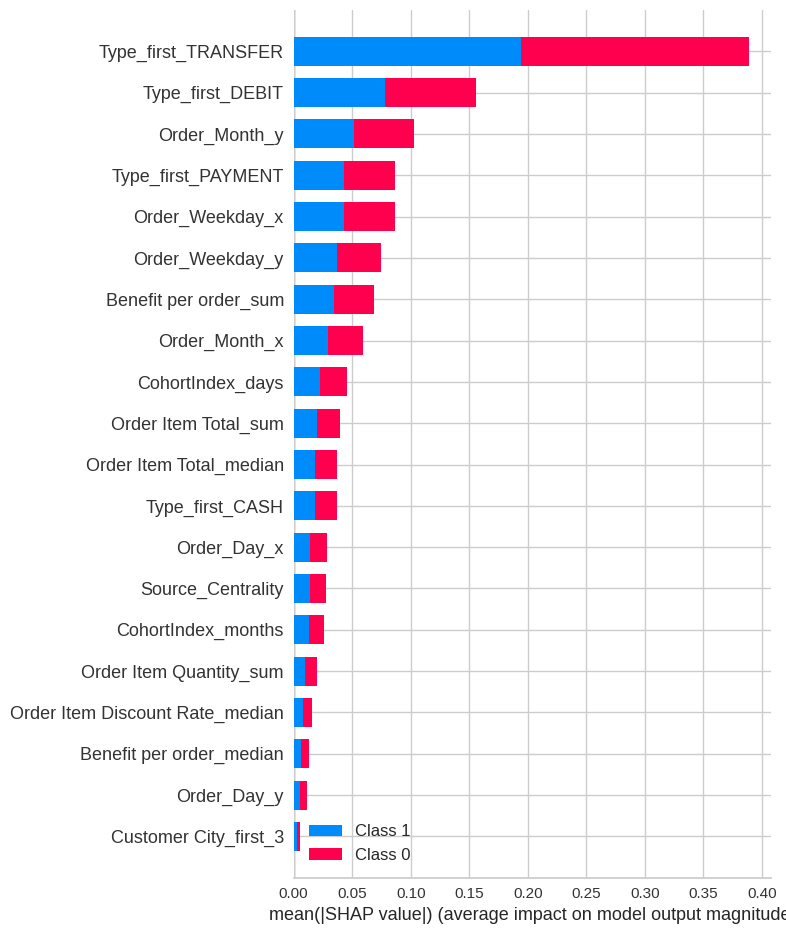

In [22]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar')

The overoptimistc performance were caused by the mixing of generate data on both the training and testing data. This has lead to (again) data leakage in the dataset.